In [267]:
import pandas as pd
from scipy.optimize import curve_fit, fsolve
import math
import numpy as np
from matplotlib import pyplot as plt

In [268]:
colnames = ["time" , "label", "tctemp", "label1k", "1kval","label10k", "10kval","label100k", "100kval"]
raw_csv = pd.read_csv("heatdata2.csv",names = colnames, header = None)
print(raw_csv)

              time     label  tctemp label1k  1kval label10k  10kval  \
0    15:44:47.524    temp tc  169.25     1k     553      10k     938   
1    15:44:48.654    temp tc  168.50     1k     548      10k     937   
2    15:44:49.834    temp tc  167.75     1k     544      10k     936   
3    15:44:50.963    temp tc  167.25     1k     540      10k     934   
4    15:44:52.086    temp tc  166.50     1k     536      10k     933   
..             ...       ...     ...     ...    ...      ...     ...   
743  15:59:01.238    temp tc   40.50     1k      22      10k     175   
744  15:59:02.421    temp tc   40.50     1k      22      10k     175   
745  15:59:03.546    temp tc   40.50     1k      22      10k     175   
746  15:59:04.720    temp tc   40.50     1k      22      10k     175   
747  15:59:05.843    temp tc   40.25     1k      22      10k     175   

    label100k  100kval  
0        100k     1011  
1        100k     1011  
2        100k     1011  
3        100k     1011  
4        1

<AxesSubplot:title={'center':'thermocouple temp v time'}, xlabel='time'>

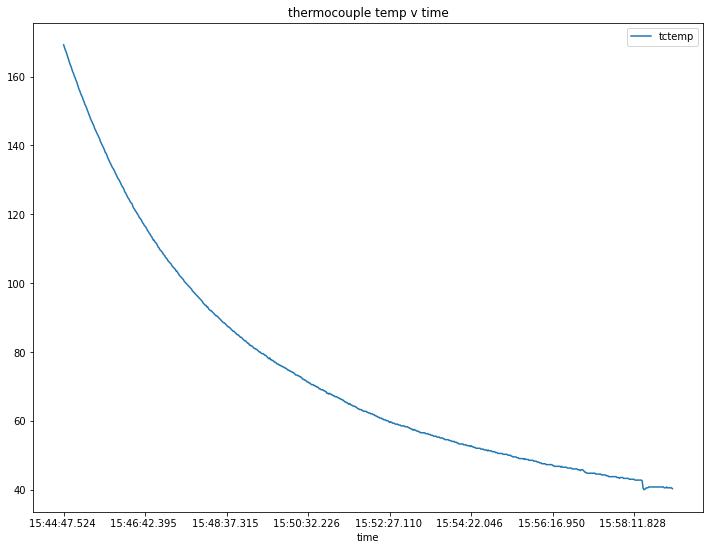

In [269]:
#plot temp vs time
plotscale = 3
raw_csv.plot(x="time" , y = "tctemp", figsize = [4*plotscale,3*plotscale], title= "thermocouple temp v time")

<AxesSubplot:title={'center':'raw ADC vs thermocouple'}, xlabel='tctemp', ylabel='ADC raw'>

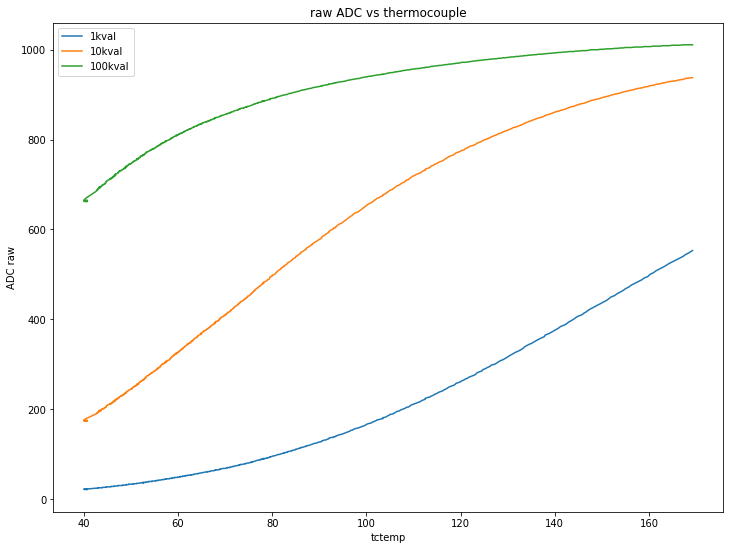

In [270]:
#plot temp vs resistor divider val
plotscale = 3
raw_csv.plot(x="tctemp" , y = ["1kval","10kval", "100kval"], figsize = [4*plotscale,3*plotscale], title = "raw ADC vs thermocouple", ylabel="ADC raw")

[ 8.52409353e+02  1.44866779e+02  2.87090819e-02 -1.95715933e+01]
[ 1.17359188e+03  6.99341409e+01  2.90550841e-02 -1.76135413e+02]
logistic cuve not a good fit
[ 3.07397085e-04 -1.21471649e-01  1.68227510e+01  1.68636496e+02]
[['1kval', array([ 8.52409353e+02,  1.44866779e+02,  2.87090819e-02, -1.95715933e+01]), 'logistic'], ['10kval', array([ 1.17359188e+03,  6.99341409e+01,  2.90550841e-02, -1.76135413e+02]), 'logistic'], ['100kval', array([ 3.07397085e-04, -1.21471649e-01,  1.68227510e+01,  1.68636496e+02]), 'poly4']]


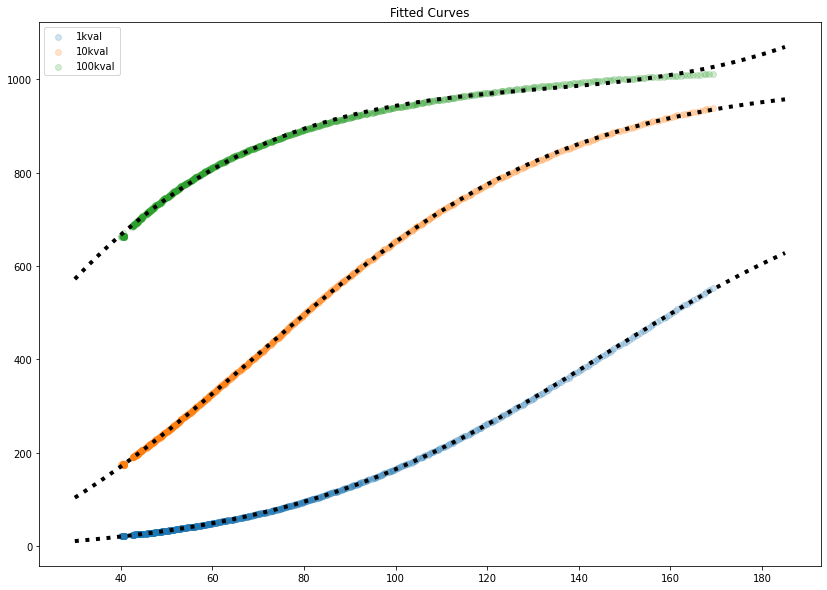

In [271]:
#https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
#curve fit

def shape_logistic(x, L , x0 ,k, off):
    ret = (L/(1+np.exp(-k*(x-x0))))+off
    return ret

def shape_poly4(x,a,b,c,d):#k,off):
#     ret = k*np.log(x)+offl
    ret = a*x**3+b*x**2+c*x+d
    return ret

xvals =raw_csv["tctemp"].tolist()
tempx = np.linspace(30,185,num=140)
plt.figure(figsize=(14,10))

fits=[]

for datacol in raw_csv[["1kval","10kval", "100kval"]]:
    fitType = None
    col = raw_csv[datacol]
    yvals =col.tolist()

    p0 = [max(yvals), np.median(xvals),1,min(yvals)] # this is an mandatory initial guess
    
    try:
        param, param_cov = curve_fit(shape_logistic, xvals, yvals, p0, method='dogbox')
        fitcurve = shape_logistic(tempx, *param)
        fitType = "logistic"
    except RuntimeError:
        print("logistic cuve not a good fit")
        param, param_cov = curve_fit(shape_poly4, xvals, yvals)
        fitcurve = shape_poly4(tempx, *param)
        fitType = "poly4"
    fits.append([datacol,param,fitType])
    
    print(param)
    

    
    plt.scatter(xvals,yvals, alpha=.2, label = datacol)
    plt.plot(tempx, fitcurve, c="k", ls = ":", lw =4)

plt.title("Fitted Curves")
plt.legend()
print(fits)


temp switchover: [118.87232954]
min slope: [5.33940549]


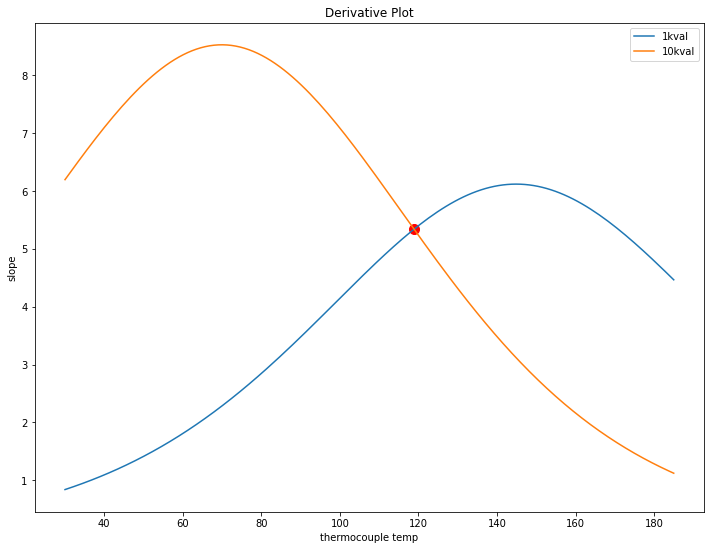

In [272]:
#look at derivatives to figure out where we should switch from one model to the next
#high derivative = good
plt.figure(figsize=(4*3,3*3))
plt.xlabel("thermocouple temp")
plt.ylabel("slope")
plt.title("Derivative Plot")

#the shape of the derivative of the logistic curve
def shape_logistic_deriv(x, L , x0 ,k, off):
    ret = (k*L*np.exp(k*(x+x0))) / (np.exp(k*x)+np.exp(k*x0))**2
    return ret



def findIntersection(fun1,fun2,x0):
 return fsolve(lambda x : fun1(x) - fun2(x),x0)


#deriv shape with 1k params
def shape_logistic1k(x):
    return shape_logistic_deriv(x,*(fits[0][1]))


#deriv shape with 10k params
def shape_logistic10k(x):
    return shape_logistic_deriv(x,*(fits[1][1]))
    
#find temp at which 1k and 10k derivative curves meet
result = findIntersection(shape_logistic1k ,shape_logistic10k  , 120)


matchpoint_y = shape_logistic1k(result)
matchpoint_x = result

print("temp switchover: "+str(result))
print("min slope: "+str(matchpoint_y))


#only look at the first two fits, for 1k and 10k
for fitted in fits[:2]:
    if(fitted[2] == "logistic"):
        fitcurve = shape_logistic_deriv(tempx, *fitted[1])
    plt.plot(tempx, fitcurve, label=fitted[0])
plt.legend()
plt.scatter(matchpoint_x, matchpoint_y, c='r', s=100)


1kval params : [ 8.52409353e+02  1.44866779e+02  2.87090819e-02 -1.95715933e+01]
10kval params : [ 1.17359188e+03  6.99341409e+01  2.90550841e-02 -1.76135413e+02]
1kval crossover adc val: [254.59147841]
10kval crossover adc val: [769.35316296]


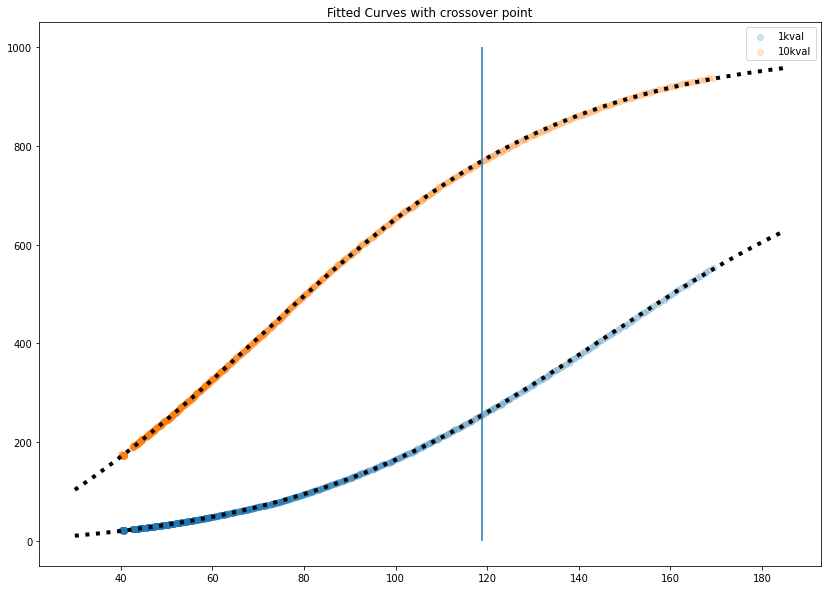

In [287]:
#replot the fits with the cutover

plt.figure(figsize=(14,10))
for datacol in raw_csv[["1kval","10kval"]]:
    fitType = None
    col = raw_csv[datacol]
    yvals =col.tolist()

    p0 = [max(yvals), np.median(xvals),1,min(yvals)] # this is an mandatory initial guess
    
    try:
        param, param_cov = curve_fit(shape_logistic, xvals, yvals, p0, method='dogbox')
        fitcurve = shape_logistic(tempx, *param)
        fitType = "logistic"
    except RuntimeError:
        print("logistic cuve not a good fit")
        param, param_cov = curve_fit(shape_poly4, xvals, yvals)
        fitcurve = shape_poly4(tempx, *param)
        fitType = "poly4"
    fits.append([datacol,param,fitType])
    
    
    print(datacol +" params : " +str(param))
    

    
    plt.scatter(xvals,yvals, alpha=.2, label = datacol)
    plt.plot(tempx, fitcurve, c="k", ls = ":", lw =4)

plt.vlines(matchpoint_x,0,1000)
plt.title("Fitted Curves with crossover point")
plt.legend()

for fitted in fits[:2]:
    if(fitted[2] == "logistic"):
        fitcurve = shape_logistic(matchpoint_x, *fitted[1])
        print(fitted[0]+" crossover adc val: "+str(fitcurve))

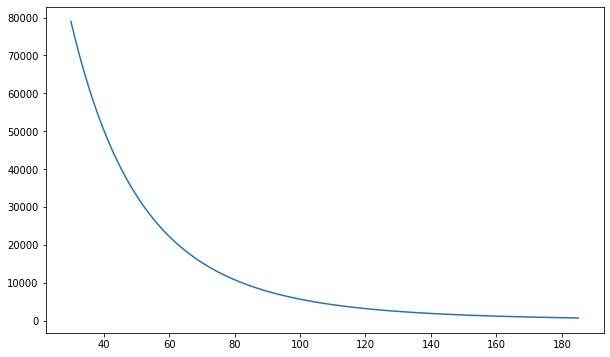

In [273]:
R0 = 100000
T0 = 298.15 #25c in K
Beta = 4267
def betaApprox(temps, B):
    ret = []
    for temp in temps:
        ret.append( R0*np.exp(B*((1/(temp+273.15))-(1/T0))))
    return ret
        
beta_curve=betaApprox(tempx,Beta)
plt.figure(figsize=(10,6))
plt.plot(tempx,beta_curve)